## Conclusion

This section is aim to finding out how the variable are associated with wheather a user is  verified by logistic regression model.

1. The model had decent predictive power about verified status. Based on the model coefficients from the logistic regression, `claim_status` and `author_ban_status` tend to be associated with higher odds of the user being verified. Other video features have small estimated coefficients in the model, so their association with verified status seems to be small.

2. The logistic regression model had not great, but acceptable predictive power: a precision of 63% is less than ideal, but a recall of 81% is good. Overall accuracy is towards the lower end of what would typically be considered acceptable. 

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Import packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample


# Import packages for data modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [2]:
# Load dataset into dataframe
df = pd.read_csv("tiktok_dataset.csv")

### **1. Check data**

In [3]:
# Display first few rows
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [4]:
# Get number of rows and columns
df.shape


(19382, 12)

In [5]:
# Get data types of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [6]:
# Generate basic descriptive stats
df.describe()


,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


### **2. Clean and modify data**

In [7]:
# Display first few rows after handling missing values
df.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [8]:
# Drop rows with missing values
df = df.dropna(axis = 0)

In [9]:
# Check for duplicates
df.duplicated().sum()

0

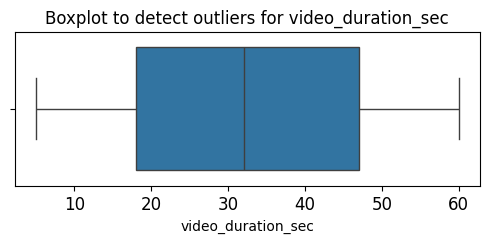

In [10]:
# Create a boxplot to visualize distribution of `video_duration_sec`
def boxploter(da, column):
    plt.figure(figsize=(6, 2))
    plt.title(f"Boxplot to detect outliers for {column}")
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    sns.boxplot(data = da, x = column)
    plt.show()

boxploter(df, "video_duration_sec")



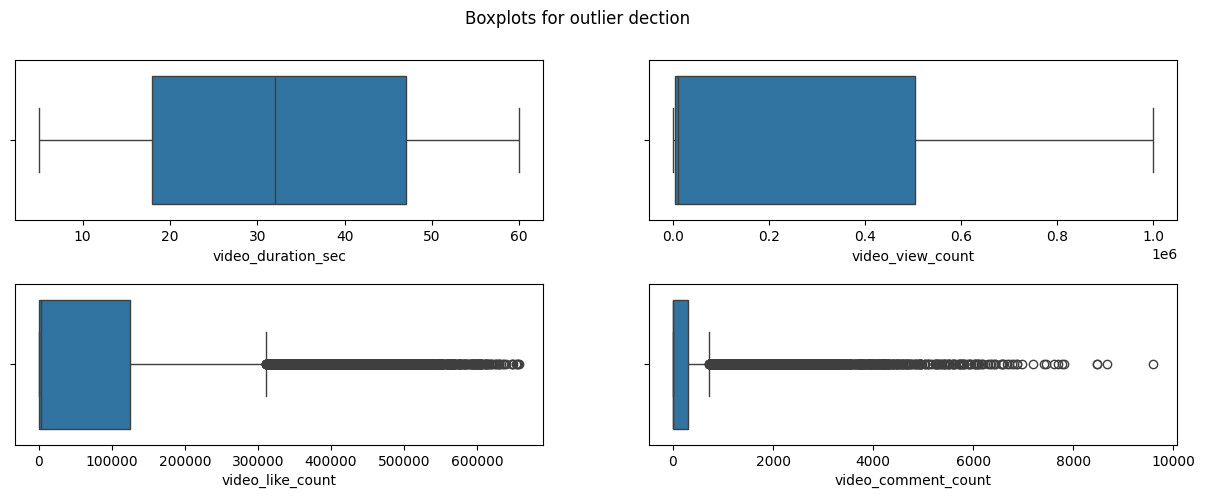

In [11]:
# Create a boxplot to visualize distribution of `video_view_count`
fig, axes = plt.subplots(2, 2, figsize = (15, 5 ))
fig.suptitle("Boxplots for outlier dection")
sns.boxplot(ax = axes[0][0], x = df["video_duration_sec"])
sns.boxplot(ax = axes[0][1], x = df["video_view_count"])
sns.boxplot(ax = axes[1][0], x = df["video_like_count"])
sns.boxplot(ax = axes[1][1], x = df["video_comment_count"])
plt.subplots_adjust(hspace=0.4)
plt.show()



In [12]:
# Check for and handle outliers for video_like_count and video_comment_count
def outliershandler(data, column):
    percent25 = data[column].quantile(0.25)
    percent75 = data[column].quantile(0.75)
    iqr = percent75 - percent25
    upper_limit = percent75 + 1.5 * iqr
    data.loc[data[column] > upper_limit, column] = upper_limit

outliershandler(df, "video_like_count")
outliershandler(df, "video_comment_count")

df[["video_like_count", "video_comment_count"]].describe()


,video_like_count,video_comment_count
count,19084.000000,19084.000000
mean,74323.538632,181.023501
std,107103.555220,272.084766
min,0.000000,0.000000
25%,810.750000,1.000000
50%,3403.500000,9.000000
75%,125020.000000,292.000000
max,311333.875000,728.500000


In [13]:
# Check class balance for video_comment_count
print("verified status counts:", df["verified_status"].value_counts())
print("verified status ratio:", df["verified_status"].value_counts(normalize=True))

verified status counts: verified_status
not verified    17884
verified         1200
Name: count, dtype: int64
verified status ratio: verified_status
not verified    0.93712
verified        0.06288
Name: proportion, dtype: float64


94.2% of the dataset represents videos posted by unverified accounts and 5.8% represents videos posted by verified accounts.

The outcome variable is not very balanced, so use resampling to create class balance in the outcome variable.

In [14]:
# Use resampling to create class balance in the outcome variable, if needed

# Identify data points from majority and minority classes
majority = df[df["verified_status"] == "not verified"]
minority = df[df["verified_status"] == "verified"]

# Upsample the minority class (which is "verified")
minority_upsampled = resample(minority,
                                 replace=True,
                                 n_samples=len(majority),
                                 random_state=0)               


# Combine majority class with upsampled minority class
data_upsampled = pd.concat([majority, minority_upsampled]).reset_index(drop = True)

# Display new class counts
data_upsampled["verified_status"].value_counts()

verified_status
not verified    17884
verified        17884
Name: count, dtype: int64

### **3. Create new feature**
`text_length`

In [15]:
# Get the average `video_transcription_text` length for claims and the average `video_transcription_text` length for opinions
data_upsampled[["verified_status", "video_transcription_text"]].groupby(by="verified_status")[["video_transcription_text"]].agg(lambda arry : np.mean([len(text) for text in arry]) )

,video_transcription_text
verified_status,
not verified,89.401141
verified,84.569559


In [16]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
data_upsampled["text_length"] = data_upsampled["video_transcription_text"].apply(lambda x : len(x))
data_upsampled.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


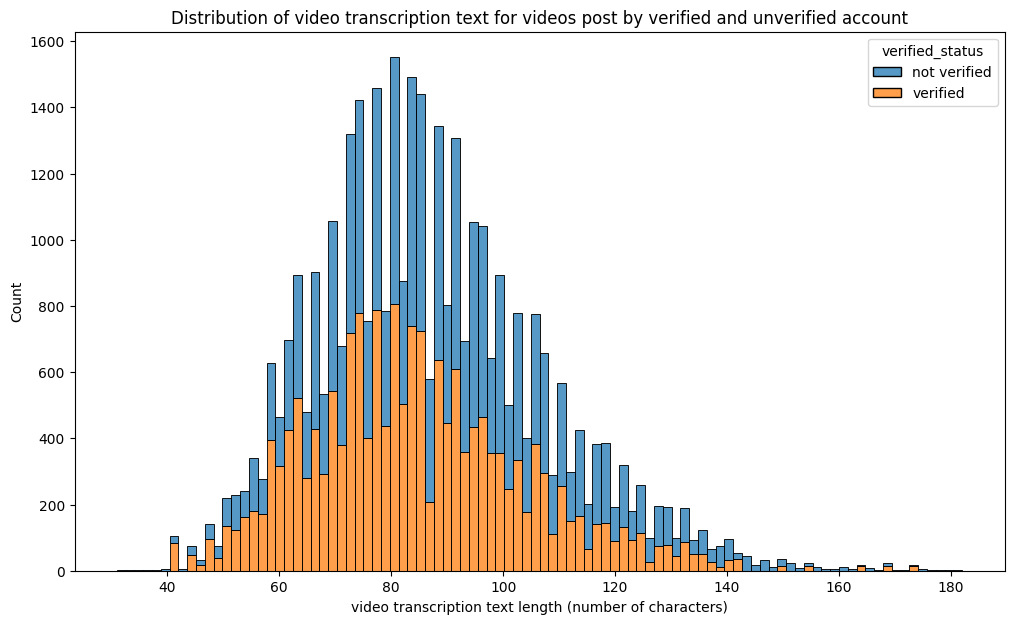

In [17]:
# Visualize the distribution of `video_transcription_text` length for videos posted by verified accounts and videos posted by unverified accounts
# Create two histograms in one plot
plt.figure(figsize = (12, 7))
plt.title("Distribution of video transcription text for videos post by verified and unverified account")
sns.histplot(data = data_upsampled,
             multiple = "stack", 
             x = "text_length", 
             hue = "verified_status", 
             legend = True )
plt.xlabel("video transcription text length (number of characters)")
plt.show()




### **4. Examine correlations**

Next, code a correlation matrix to help determine most correlated variables.

In [18]:
# Code a correlation matrix to help determine most correlated variables
data_upsampled.corr(numeric_only = True)


,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
#,1.000000,-0.000853,-0.011729,-0.697007,-0.626385,-0.504015,-0.487096,-0.608773,-0.193677
video_id,-0.000853,1.000000,0.011859,0.002554,0.005993,0.010515,0.008753,0.012674,-0.007083
video_duration_sec,-0.011729,0.011859,1.000000,0.013589,0.004494,0.002206,0.003989,-0.001086,-0.002981
video_view_count,-0.697007,0.002554,0.013589,1.000000,0.856937,0.711313,0.690048,0.748361,0.244693
video_like_count,-0.626385,0.005993,0.004494,0.856937,1.000000,0.832146,0.805543,0.818032,0.216693
video_share_count,-0.504015,0.010515,0.002206,0.711313,0.832146,1.000000,0.710117,0.671335,0.171651
video_download_count,-0.487096,0.008753,0.003989,0.690048,0.805543,0.710117,1.000000,0.793668,0.173396
video_comment_count,-0.608773,0.012674,-0.001086,0.748361,0.818032,0.671335,0.793668,1.000000,0.217661
text_length,-0.193677,-0.007083,-0.002981,0.244693,0.216693,0.171651,0.173396,0.217661,1.000000


Visualize a correlation heatmap of the data.

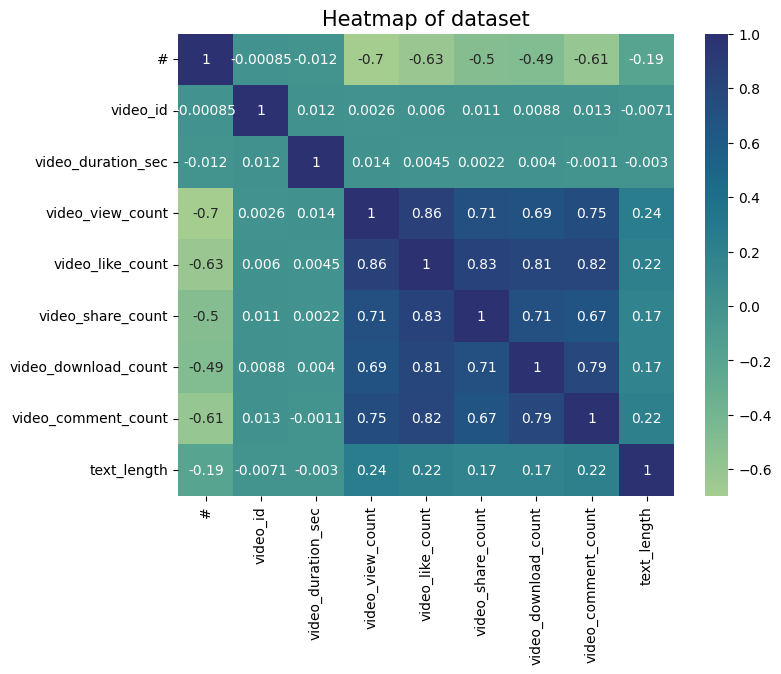

In [19]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize = (8, 6))
sns.heatmap(data = data_upsampled.corr(numeric_only = True), annot = True, cmap = "crest")
plt.title("Heatmap of dataset", fontsize = 15)
plt.show()


### **5. Encode data and train model**

In [20]:
# Select outcome variable
y = data_upsampled["verified_status"]

# Select features
x = data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", "video_share_count", "video_download_count", "video_comment_count"]]


In [21]:
# Set up an encoder for one-hot encoding the categorical features
x_encoder = OneHotEncoder(drop = "first", sparse_output = False)

# Fit and transform the training features using the encoder
x_encoded = x_encoder.fit_transform(x[["claim_status", "author_ban_status"]])

# Place encoded training features (which is currently an array) into a dataframe
x_encoded_df = pd.DataFrame(data = x_encoded, columns = x_encoder.get_feature_names_out())

# Display first few rows
x_encoded_df.head()


,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,0.0,0.0,1.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [22]:
# Concatenate `X_train` and `X_train_encoded_df` to form the final dataframe for training data (`X_train_final`)
x = pd.concat([x.drop(["claim_status", "author_ban_status"], axis = 1).reset_index(drop = True), x_encoded_df], axis = 1)

# Display first few rows
x.head()


,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,59,343296.0,241.0,1.0,0.0,0.0,0.0,1.0
1,32,140877.0,19034.0,1161.0,684.0,0.0,0.0,0.0
2,31,902185.0,2858.0,833.0,329.0,0.0,0.0,0.0
3,25,437506.0,34812.0,1234.0,584.0,0.0,0.0,0.0
4,19,56167.0,4110.0,547.0,152.0,0.0,0.0,0.0


In [23]:
# Set up an encoder for one-hot encoding the categorical outcome variable
y_encoder = OneHotEncoder(drop = "first", sparse_output = False)

# Encode the training outcome variable
y = y_encoder.fit_transform(y.values.reshape(-1, 1)).ravel()

# Display the encoded training outcome variable
y

array([0., 0., 0., ..., 1., 1., 1.])

In [24]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 0)

In [25]:
# Construct a logistic regression model and fit it to the training set
log_clf = LogisticRegression(random_state = 0, max_iter = 800).fit(x_train, y_train)


### **6. Summarize model results**

In [26]:
# Use the logistic regression model to get predictions on the encoded testing set
y_pred = log_clf.predict(x_test)


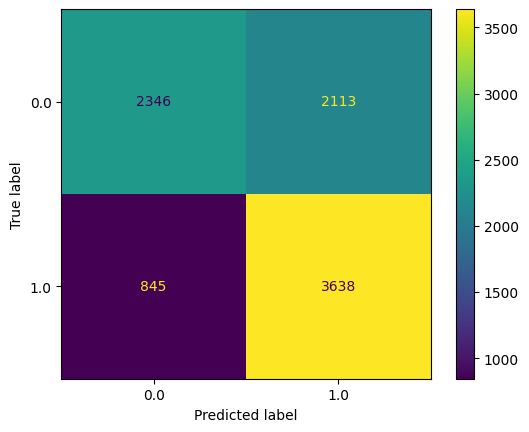

In [27]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels = log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix = log_cm, display_labels = log_clf.classes_)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

In [28]:
# Create a classification report
target_labels = ["not_verified", "verified"]
print(classification_report(y_test, y_pred, target_names = target_labels))

              precision    recall  f1-score   support

not_verified       0.74      0.53      0.61      4459
    verified       0.63      0.81      0.71      4483

    accuracy                           0.67      8942
   macro avg       0.68      0.67      0.66      8942
weighted avg       0.68      0.67      0.66      8942



In [29]:
# Get the feature names from the model and the model coefficients
Feature_importance = pd.DataFrame( {"Coefficient" : log_clf.coef_[0]}, index = log_clf.feature_names_in_)
Feature_importance

,Coefficient
video_duration_sec,-3.310671e-03
video_view_count,-3.479063e-07
video_share_count,4.980044e-06
video_download_count,-7.224096e-05
video_comment_count,3.324692e-04
claim_status_opinion,1.515337e+00
author_ban_status_banned,-5.725635e-01
author_ban_status_under review,-4.232191e-01


C:\Users\PC\AppData\Local\Temp\ipykernel_320\3345103841.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


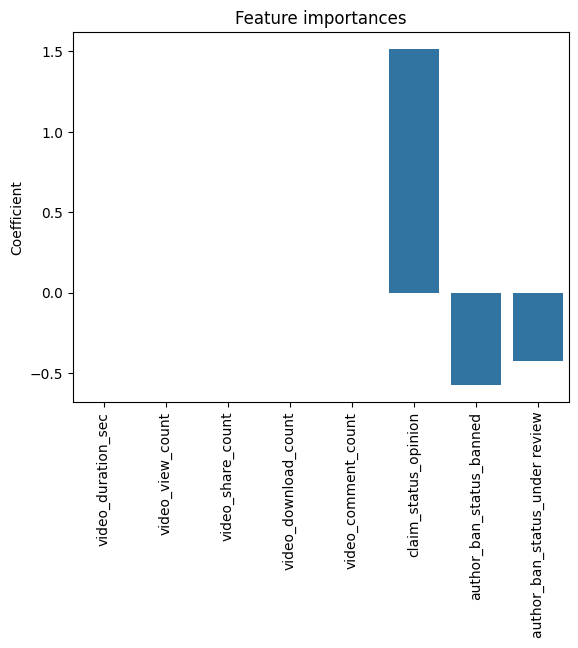

In [30]:
importances = Feature_importance["Coefficient"]
plot = sns.barplot(data = importances)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.title("Feature importances")
plt.show()